# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
SYMBOL = 'BTCUSDT'
window_size = 20
stride = 5 

df_final        = pd.read_csv(f'data/subsequences/df_final_{SYMBOL}_ws={window_size}_stride={stride}.csv', parse_dates=['Close_Time'], index_col='Close_Time').sort_index()
subsequences_df = pd.read_csv(f'data/subsequences/subseq_{SYMBOL}_ws={window_size}_stride={stride}.csv')
subseq_times_df = pd.read_csv(f'data/subsequences/subseqtimes_{SYMBOL}_ws={window_size}_stride={stride}.csv', header=None, names=['start_idx'])[1:].reset_index(drop=True)
embeddings_df   = pd.read_csv(f'data/embeddings/embed_vae_dtw_shape_{SYMBOL}_ws{window_size}_ld{stride}.csv')
labels_df       = pd.read_csv(f'data/communities/labels_{SYMBOL}_ws={window_size}_stride={stride}.csv', header=None, names=['community_id'])
keep_df         = pd.read_csv(f'data/communities/keep_{SYMBOL}_ws={window_size}_stride={stride}.csv', header=None, names=['keep_id'])
centroids_df    = pd.read_csv(f'data/communities/centroids_{SYMBOL}_ws={window_size}_stride={stride}.csv', header=None)
node_labels_df  = pd.read_csv(f'data/communities/node_labels_{SYMBOL}_ws={window_size}_stride={stride}.csv', header=None, names=['motif_id'])


In [3]:
df_final.shape, subsequences_df.shape, subseq_times_df.shape, embeddings_df.shape

((3798962, 1), (759789, 20), (759789, 1), (759789, 5))

In [4]:
labels_df.shape, keep_df.shape, node_labels_df.shape

((759789, 1), (363, 1), (759789, 1))

In [5]:
node_labels_df

,motif_id
0,181
1,278
2,278
3,21
4,21
...,...
759784,69
759785,69
759786,69
759787,69


In [6]:
df_final

,Log_Close_Z
Close_Time,
2018-01-01 00:00:59.999000,-0.451902
2018-01-01 00:01:59.999000,-0.452937
2018-01-01 00:02:59.999000,-0.454127
2018-01-01 00:03:59.999000,-0.456843
2018-01-01 00:04:59.999000,-0.460526
...,...
2025-03-28 23:55:59.999999,1.531203
2025-03-28 23:56:59.999999,1.531203
2025-03-28 23:57:59.999999,1.531203


In [7]:
subseq_times_df

,start_idx
0,0
1,5
2,10
3,15
4,20
...,...
759784,3798920
759785,3798925
759786,3798930
759787,3798935


In [8]:
start_idxs = subseq_times_df['start_idx'].astype(int).values
assert start_idxs.max() + window_size <= len(df_final), "Index out of bounds!"

# Map the indices to actual timestamps
subseq_times = df_final.index[start_idxs] 

In [9]:
keep_ids = set(keep_df['keep_id'])

In [10]:
tokens_df = pd.DataFrame({
    'start_time': subseq_times,
    'motif_id':   node_labels_df['motif_id'].values
})
tokens_df

,start_time,motif_id
0,2018-01-01 00:00:59.999000,181
1,2018-01-01 00:05:59.999000,278
2,2018-01-01 00:10:59.999000,278
3,2018-01-01 00:15:59.999000,21
4,2018-01-01 00:20:59.999000,21
...,...,...
759784,2025-03-28 23:18:59.999999,69
759785,2025-03-28 23:23:59.999999,69
759786,2025-03-28 23:28:59.999999,69
759787,2025-03-28 23:33:59.999999,69


In [11]:
tokens_df = tokens_df[tokens_df['motif_id'].isin(keep_ids)]
tokens_df = tokens_df.sort_values('start_time').reset_index(drop=True)
tokens_df

,start_time,motif_id
0,2018-01-01 00:00:59.999000,181
1,2018-01-01 00:05:59.999000,278
2,2018-01-01 00:10:59.999000,278
3,2018-01-01 00:15:59.999000,21
4,2018-01-01 00:20:59.999000,21
...,...,...
752593,2025-03-28 23:18:59.999999,69
752594,2025-03-28 23:23:59.999999,69
752595,2025-03-28 23:28:59.999999,69
752596,2025-03-28 23:33:59.999999,69


In [12]:
token_sequence = tokens_df['motif_id'].to_numpy()

In [13]:
print(tokens_df.head())
print(f"Kept subsequences: {len(tokens_df)}, which is {len(tokens_df)/subseq_times.shape[0] * 100 :.2f}% of the original length.")
print(f"Unique motifs: {tokens_df['motif_id'].nunique()}")

               start_time  motif_id
0 2018-01-01 00:00:59.999       181
1 2018-01-01 00:05:59.999       278
2 2018-01-01 00:10:59.999       278
3 2018-01-01 00:15:59.999        21
4 2018-01-01 00:20:59.999        21
Kept subsequences: 752598, which is 99.05% of the original length.
Unique motifs: 363


# Validation

In [14]:
node_labels = np.array(node_labels_df["motif_id"])

In [15]:
window_size = subsequences_df.shape[1]
K = np.unique(node_labels[node_labels >= 0]).size
centroids = np.zeros((K, window_size))
counts = np.zeros(K, dtype=int)
for idx, m in enumerate(node_labels):
    if m >= 0:
        centroids[m] += subsequences_df.values[idx]
        counts[m]   += 1
centroids /= counts[:,None]

In [19]:
# Sample some motif IDs
np.random.seed(42)
sample_motifs = np.random.choice(K, size=5, replace=False)

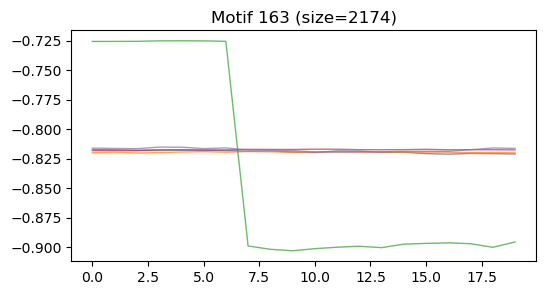

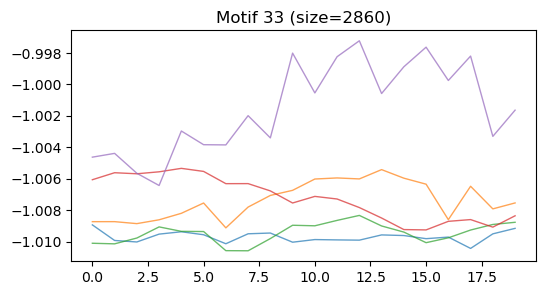

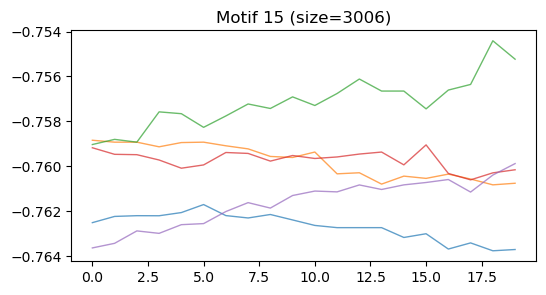

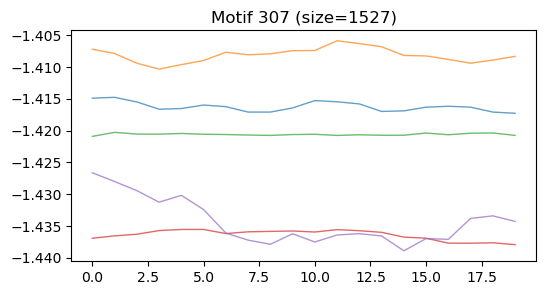

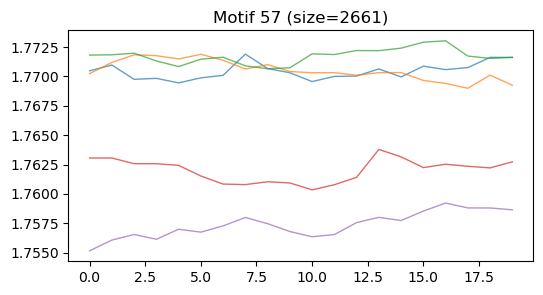

In [20]:
# For each motif, pick 5 windows at random and plot
for m in sample_motifs:
    members = np.where(node_labels == m)[0]
    if len(members) == 0: continue
    picks = np.random.choice(members, size=min(5,len(members)), replace=False)
    
    plt.figure(figsize=(6,3))
    for i in picks:
        plt.plot(subsequences_df.values[i], alpha=0.7, linewidth=1)
    # plt.plot(centroids[m], color='black', linewidth=2, label='centroid')
    plt.title(f"Motif {m} (size={counts[m]})")
    # plt.legend()
    plt.show()